In [88]:
import os
import pandas as pd
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
import albumentations as A
import matplotlib.pyplot as plt

In [89]:
# 데이터 경로를 입력하세요.  
IMAGE_ROOT = "/data/ephemeral/home/data/test/DCM"
CSV_LABEL_PATH = "/data/ephemeral/home/hwcho/output.csv"

In [90]:
# CSV 데이터 로드
df = pd.read_csv(CSV_LABEL_PATH)

In [91]:
# 각 클래스별로 고유 인덱스 매핑
CLASSES = sorted(df['class'].unique())
CLASS2IND = {cls: i for i, cls in enumerate(CLASSES)}
IND2CLASS = {i: cls for cls, i in CLASS2IND.items()}

In [131]:
class XRayDataset(Dataset):
    def __init__(self, filenames, labels_df, transforms=None, is_train=False):
        self.filenames = filenames
        self.labels_df = labels_df
        self.is_train = is_train
        self.transforms = transforms
        self.CLASSES = CLASSES
        self.CLASS2IND = CLASS2IND
        self.IMAGE_ROOT = IMAGE_ROOT  # 이미지 루트 경로 설정

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        image_name = self.filenames[item]
        
        # IMAGE_ROOT 내의 폴더를 순회하며 이미지 파일 찾기
        for folder_id in os.listdir(self.IMAGE_ROOT):
            folder_path = os.path.join(self.IMAGE_ROOT, folder_id)
            if os.path.isdir(folder_path):
                # 폴더 내에서 해당 이미지 파일 찾기
                image_path = os.path.join(folder_path, image_name)
                if os.path.exists(image_path):
                    break
        else:
            # 이미지 경로를 찾지 못한 경우 에러 처리
            print(f"Error: {image_name} not found in any folder under {self.IMAGE_ROOT}")
            return None, None
        
        try:
            # 이미지 로드
            image = cv2.imread(image_path)
            if image is None:
                raise FileNotFoundError(f"Unable to load image at {image_path}")  # 이미지 로드 실패 시 에러 처리
            image = image / 255.0  # 정규화

            # 레이블 초기화
            label_shape = (image.shape[0], image.shape[1], len(self.CLASSES))
            label = np.zeros(label_shape, dtype=np.uint8)

            # 현재 이미지에 해당하는 레이블 행 찾기
            image_labels = self.labels_df[self.labels_df['image_name'] == image_name]
            
            for _, row in image_labels.iterrows():
                label_id = row['class']
                rle = row['rle']  # rle 컬럼에서 데이터 추출
                points = self.rle_to_points(rle, image.shape)  # RLE를 좌표로 변환
                
                # 해당 클래스를 위한 마스크 생성
                class_label = np.zeros(image.shape[:2], dtype=np.uint8)
                cv2.fillPoly(class_label, [points], 1)  # 다각형을 마스크로 채우기
                label[..., self.CLASS2IND[label_id]] = np.maximum(label[..., self.CLASS2IND[label_id]], class_label)

            # 변환 적용
            if self.transforms:
                inputs = {"image": image, "mask": label} if self.is_train else {"image": image}
                result = self.transforms(**inputs)
                image = result["image"]
                label = result["mask"] if self.is_train else label


            # 이미지와 레이블을 (C, H, W) 형태로 변환
            image = image.transpose(2, 0, 1)  # (H, W, C) -> (C, H, W)
            label = label.transpose(2, 0, 1)

            image = torch.from_numpy(image).float()
            label = torch.from_numpy(label).float()

            return image, label

        except Exception as e:
            print(f"Error: {e}")
            return None, None

    def rle_to_points(self, rle, shape):
        """
        RLE (Run Length Encoding)를 사용하여 픽셀 좌표를 반환하는 함수
        """
        rle = list(map(int, rle.split()))  # RLE 문자열을 정수로 변환
        points = []
        for i in range(0, len(rle), 2):
            start = rle[i]
            length = rle[i + 1]
            # RLE의 시작점과 길이를 바탕으로 좌표 생성
            for j in range(start, start + length):
                points.append([j % shape[1], j // shape[1]])  # (x, y) 좌표 계산
        return np.array(points, dtype=np.int32)



# 색상 정의
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

In [134]:
def label2rgb(label):
    image_size = label.shape[:2] + (3,)
    image = np.zeros(image_size, dtype=np.uint8)

    for i in range(label.shape[2]):  # label.shape[2] = number of classes
        image[label[:, :, i] == 1] = PALETTE[i]  # Apply color from PALETTE

    return image


# 이미지 시각화 함수
def visualize_images_and_labels(image, label):
    if image is None or label is None:
        print("Error: Image or label is None. Cannot visualize.")
        return

    image = image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    label = label.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

    label_overlay = label2rgb(label)
    image = (image * 255).astype(np.uint8)

    alpha = 0.5
    output_image = cv2.addWeighted(image, 1, label_overlay, alpha, 0)

    for i in range(label.shape[2]):
        if np.any(label[:, :, i]):  # Check if the class mask exists
            class_name = IND2CLASS[i]
            contours, _ = cv2.findContours(label[:, :, i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                M = cv2.moments(contours[0])
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                cv2.putText(output_image, class_name, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0, 1), 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(output_image)
    plt.title("Image with Segmentation Mask")
    plt.axis('off')
    plt.show()

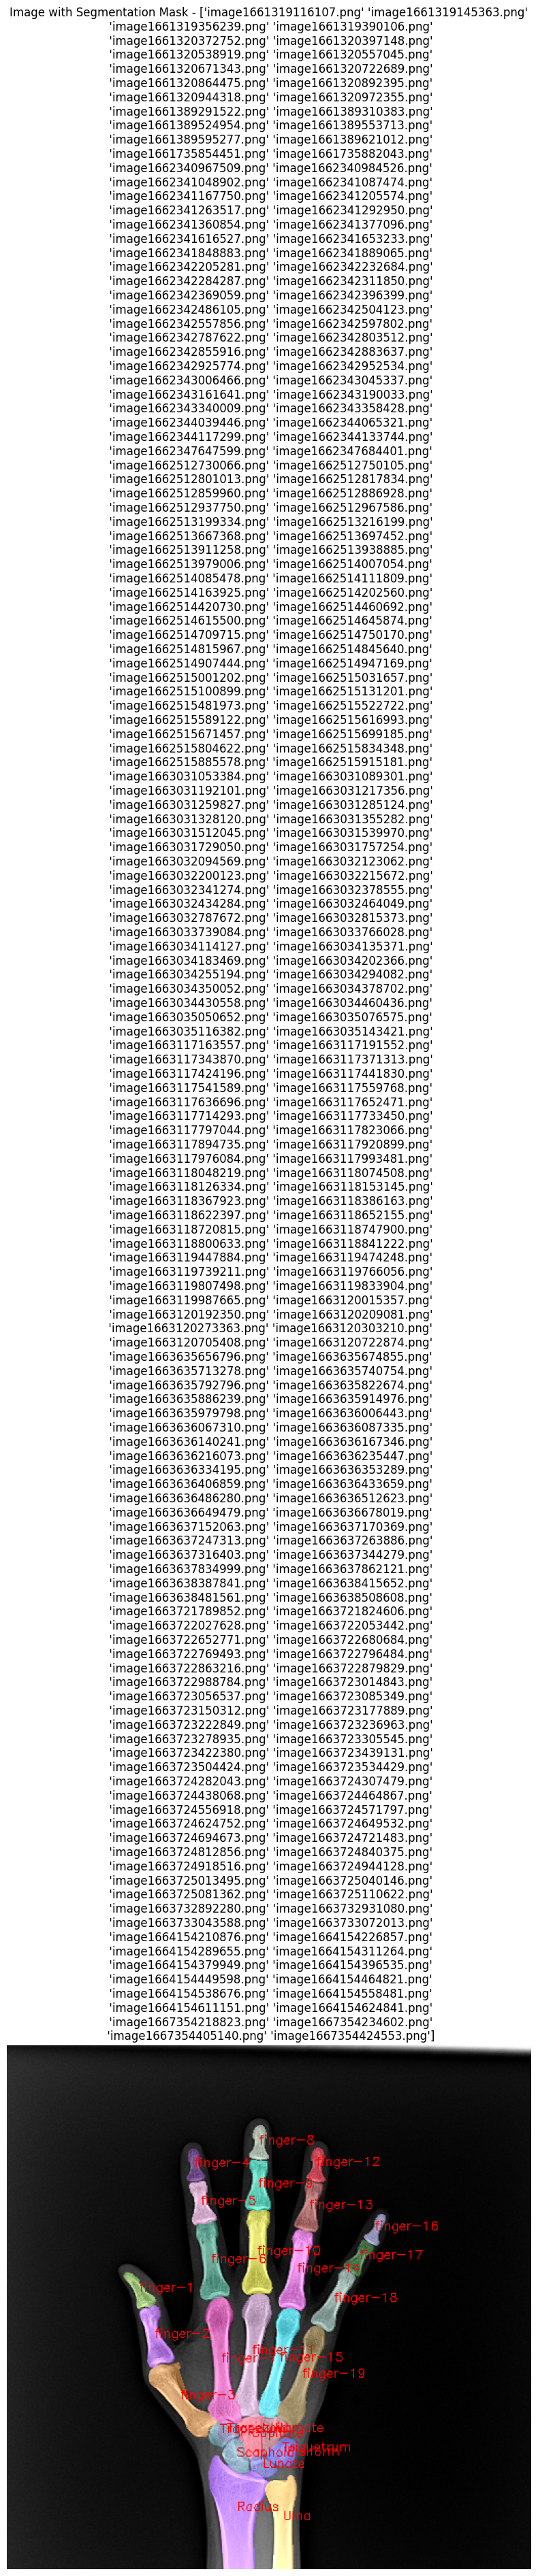

In [135]:
# 이미지와 레이블 시각화
filenames = df['image_name'].unique()
transform = A.Resize(512, 512)
dataset = XRayDataset(filenames, df, transforms=transform, is_train=True)

# 첫 번째 이미지를 시각화
image, label = dataset[0]
visualize_images_and_labels(image, label, filenames)